In [1]:
import os
import re

import numpy as np
import pandas as pd

## 1. Собираем все токены

In [2]:
from nltk.corpus import stopwords


filter_out_tokens = ['\n', '.', ',', '!', '?', '...', ':', ';']
stop_words = set(stopwords.words('english'))
broken_files = set()

def data_to_text(data, column='lemma'):
    return ' '.join(data[column].values)

def read_data_with_filter(filename):

    rows = []
    sentences = []
    sentence = []

    with open(filename, 'r') as f:
        lines = f.readlines()
        for line in lines:
            if line == '\n' and len(sentence):
                sentences.append(sentence)
                sentence = []
            if line[0] in filter_out_tokens:
                continue
            try:
                token, stem, lemma = line.split('\t')
                # выкидываем ещё и цифры
                lemma_ = re.sub(r'_',' ', lemma)
                lemma_ = re.sub(r'[^\w\s]|[\d]|ca|re','', lemma_)
                token_ = re.sub(r'[^\w\d\s\d]','', token)
                if len(lemma) != len(lemma_):
                    continue
                lemma = lemma_
                if len(lemma) == 0 or len(lemma.strip()) == 0 or token in stop_words:
                    continue
            except Exception as e:
                print(filename, line, e)
                
            rows.append((token.lower(), stem.lower(),lemma.strip().lower()))
            sentence.append(lemma.strip().lower())



    return pd.DataFrame(rows, columns=('token', 'stem', 'lemma')), sentences

In [3]:
# Читаем все файлы, достаём все слова
topics = ['baseball', 'electronics', 'hockey', 'med', 'motorcycles', 'space']
data_path = '../../assets\\annotated-corpus'

corpuses = []
corpus_sentences = []

for topic in topics:
    cur_data_path = os.path.join(data_path, topic)
    files = os.listdir(cur_data_path)
    filenames = [os.path.join(cur_data_path, fname) for fname in files]
    print('number of files: ', len(filenames))
    for f in filenames:
        corpus, sentences = read_data_with_filter(f)
        corpuses.append(corpus)
        corpus_sentences.extend(sentences)

unique_words = set()

for c in corpuses:
    unique_tokens = pd.unique(c['lemma'])
    unique_words.update(unique_tokens.tolist())
print('num of unique words: ', len(unique_words))

number of files:  397
number of files:  393
number of files:  399
number of files:  396
number of files:  398
number of files:  394
num of unique words:  24584


## Задание 1

In [4]:
unique_words

{'novak',
 'opener',
 'demographic',
 'baggage',
 'supplement',
 'mlndal',
 'boob',
 'prawn',
 'clothing',
 'trackball',
 'electricty',
 'longterm',
 'oneyear',
 'pcmcia',
 'photon',
 'uug',
 'aldosterone',
 'babillard',
 'invest',
 'write',
 'missoula',
 'inflating',
 'destroy',
 'usa',
 'overtakes',
 'lowdose',
 'tasty',
 'desirable',
 'wacky',
 'intensity',
 'rob brown',
 'nonpitching',
 'inventing',
 'transit',
 'louis',
 'sympathetic',
 'giles',
 'engin',
 'datae',
 'pucky',
 'sparkling',
 'dill',
 'artus',
 'bitty',
 'child',
 'dseg',
 'blauser',
 'tanking',
 'path',
 'avaliable',
 'ventura',
 'persistant',
 'sturges',
 'contemporary',
 'improper',
 'fitness',
 'assayed',
 'trw',
 'odd',
 'nmm',
 'walter',
 'millstein',
 'evasive',
 'sag',
 'daylong',
 'ramage',
 'kerr',
 'squids',
 'mtlquebec',
 'sounding',
 'highspeed',
 'ravine',
 'streakers',
 'nejm',
 'malmedal',
 'modernity',
 'goldstone',
 'innercity',
 'informing',
 'petranovic',
 'nightline',
 'backyard',
 'someday',
 'c

In [5]:
import tqdm
def get_term_document_matrix(unique_words: set, documents: list[pd.DataFrame]):
    print(len(documents))
    result = []
    i = 0
    for word in tqdm.tqdm(unique_words):
        summ_freq = 0
        term_doc_vector = []
        for d in documents:
            curr_freq = len(d[d['lemma'] == word])
            term_doc_vector.append(curr_freq)
            summ_freq += curr_freq
        result.append([word, summ_freq, *term_doc_vector])
        i += 1
    result = pd.DataFrame(result)
    result.columns = ['word', 'freq', *[f'd{i}' for i in range(len(documents))]]
    result.set_index('word')
    return result

term_document_matrix_df = get_term_document_matrix(unique_words, corpuses[:100])
term_document_matrix_df

100


  1%|          | 295/24584 [00:07<10:47, 37.53it/s]


KeyboardInterrupt: 

In [83]:
term_document_matrix_df[term_document_matrix_df['freq'] > 2]

,word,freq,d0,d1,d2,d3,d4,d5,d6,d7,...,d90,d91,d92,d93,d94,d95,d96,d97,d98,d99
15,tough,3,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
22,shutout,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27,advantage,5,0,0,0,1,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
43,go,48,0,1,2,0,0,2,1,0,...,0,1,0,2,0,0,0,0,2,1
46,louis,7,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7382,pittsburgh,18,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
7390,fucking,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7396,to,4,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
7405,went,11,0,1,0,0,0,0,2,1,...,0,0,0,0,0,0,0,0,0,0


In [84]:
term_document_matrix_df.to_csv('../../assets/term_document_matrix.csv')

## Задание 2

In [155]:
def get_document_term_vector(term_document_matrix_df, doc_name):
    doc_term_vector = term_document_matrix_df
    doc_term_vector = doc_term_vector[['word', doc_name]]
    doc_term_vector = doc_term_vector[doc_term_vector[doc_name] > 0]
    return doc_term_vector

doc_term_vec = get_document_term_vector(term_document_matrix_df, 'd90')
doc_term_vec

,word,d90
46,louis,2
65,question,1
338,b,1
355,university,1
732,he,1
...,...,...
6721,saint,1
6927,mo,1
7213,hammerl,1
7341,subject,1


In [ ]:
from ..tokenizer.tokenizer import tokenize_text
def read_file(file_path):
    with open(file_path, 'r') as f:
        text = f.read()
    text = text.replace('>', '').replace('|', '').replace('\n', ' ').replace('-', '')
    return text

def annotation_2_sentence_list(doc_annotaition):

    rows = []
    sentences = []
    sentence = []

    lines = doc_annotaition.split('\n')
    for line in lines:
        if line == '\n' and len(sentence):
            sentences.append(sentence)
            sentence = []
        if line[0] in filter_out_tokens:
            continue
        try:
            token, stem, lemma = line.split('\t')
            # выкидываем ещё и цифры
            lemma_ = re.sub(r'_',' ', lemma)
            lemma_ = re.sub(r'[^\w\s]|[\d]|ca|re','', lemma_)
            token_ = re.sub(r'[^\w\d\s\d]','', token)
            if len(lemma) != len(lemma_):
                continue
            lemma = lemma_
            if len(lemma) == 0 or len(lemma.strip()) == 0 or token in stop_words:
                continue
        except Exception as e:
            print(line, e)
            
        rows.append((token.lower(), stem.lower(),lemma.strip().lower()))
        sentence.append(lemma.strip().lower())




In [207]:
import numpy as np
def tf_idf(term_document_matrix_df, documents, min_freq=5):
    filtered_term_document_matrix = term_document_matrix_df[term_document_matrix_df['freq'] > min_freq]

    total_documents = len(documents)

    # tf
    tf_idf_matrix = []
    total_words_in_documents = np.array([len(d) for d in documents])
    for i in range(len(filtered_term_document_matrix)):
        tf_ = filtered_term_document_matrix.iloc[i, 2:].values / total_words_in_documents
        idf_ = np.log(total_documents / len(tf_[tf_ > 0]))
        tf_idf_ = tf_ * idf_
        tf_idf_matrix.append([filtered_term_document_matrix.iloc[i,0], *tf_idf_])
    tf_idf_matrix = pd.DataFrame(tf_idf_matrix)
    tf_idf_matrix.columns = ['word', *[f'tfidf_score{i}' for i in range(len(documents))]]
    
    # как использовать tf-ifd как весовой коэф??
    mean_tf_idf_matrix = np.mean(tf_idf_matrix.iloc[:, 1:].values, axis=1)
    tf_idf_matrix['mean_tf_idf_score'] = mean_tf_idf_matrix

    return tf_idf_matrix

In [208]:
tf_idf_matrix = tf_idf(term_document_matrix_df, corpuses[:100])
tf_idf_matrix

,word,tfidf_score0,tfidf_score1,tfidf_score2,tfidf_score3,tfidf_score4,tfidf_score5,tfidf_score6,tfidf_score7,tfidf_score8,...,tfidf_score91,tfidf_score92,tfidf_score93,tfidf_score94,tfidf_score95,tfidf_score96,tfidf_score97,tfidf_score98,tfidf_score99,mean_tf_idf_score
0,go,0.000000,0.004933,0.031217,0.0,0.000000,0.034013,0.003889,0.000000,0.0,...,0.021912,0.0,0.012122,0.000000,0.00000,0.000000,0.0,0.028846,0.012948,0.004938
1,louis,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.001870
2,question,0.007048,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.01651,0.000000,0.0,0.023197,0.020825,0.002587
3,po,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.001885
4,david,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.001914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
453,anything,0.009714,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.020206,0.00000,0.000000,0.0,0.000000,0.000000,0.001329
454,subject,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000
455,ever,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.0,0.027940,0.000000,0.002209
456,pittsburgh,0.007297,0.000000,0.000000,0.0,0.018783,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.00000,0.014706,0.0,0.000000,0.021558,0.003438


In [209]:
tf_idf_matrix.to_csv('../../assets/tf_idf_matrix.csv')

## Задание 3

In [6]:
from gensim.models import Word2Vec


EPOCHS = 40
LOWEST_WORD_FREQUENCY=3
VECTOR_SIZE=128
WINDOW_SIZE = 5
WORKERS = 4


In [12]:
model = Word2Vec.load('hockey_training')

In [7]:
model = Word2Vec(
    corpus_sentences,
    min_count=LOWEST_WORD_FREQUENCY, 
    epochs=40,
    window=WINDOW_SIZE,
    vector_size=VECTOR_SIZE,
    workers=WORKERS,
)

model.save('../../assets/big_model')

In [8]:
words = list(model.wv.key_to_index.keys())
len(words), words

(10758,
 ['i',
  'edu',
  'the',
  'subject',
  'from',
  'organization',
  'lines',
  'in',
  'writes',
  're',
  'would',
  'article',
  'one',
  'com',
  'game',
  'e',
  'like',
  'get',
  'university',
  'nntppostinghost',
  'know',
  'time',
  'year',
  'think',
  'if',
  'a',
  'it',
  'also',
  'good',
  'this',
  'could',
  'go',
  'make',
  'well',
  'team',
  'first',
  'much',
  'see',
  'new',
  'space',
  'may',
  'people',
  'two',
  'thing',
  'say',
  'way',
  'u',
  'use',
  'even',
  'player',
  'you',
  'l',
  'need',
  'last',
  'back',
  'distribution',
  'want',
  'many',
  'anyone',
  'right',
  'and',
  'problem',
  'but',
  'used',
  'going',
  'work',
  'better',
  'take',
  'day',
  'since',
  'world',
  'help',
  'c',
  'something',
  'might',
  'what',
  'system',
  's',
  'question',
  'number',
  'fan',
  'give',
  'around',
  'still',
  'point',
  'long',
  'bike',
  'best',
  'got',
  'nasa',
  'part',
  'said',
  'as',
  'usa',
  'little',
  'so',
  '

In [43]:
def inspect_wordfreq_2_wordnumber():
    result = []
    for word_freq in [1,2,4,8,16]:
        model_ = Word2Vec(
            corpus_sentences,
            min_count=word_freq, 
            epochs=40,
            window=WINDOW_SIZE,
            vector_size=VECTOR_SIZE,
            workers=WORKERS,
        )
        words = list(model_.wv.key_to_index.keys())
        result.append([word_freq, len(words)])
    p = pd.DataFrame(result, columns=['word freq', 'unique words'])
    p.set_index('word freq', inplace=True)
    return p

inspect_wordfreq_2_wordnumber()

,unique words
word freq,
1,7416
2,4169
4,2281
8,1249
16,650


In [216]:
words = list(model.wv.key_to_index.keys())
words
player_vector = model.wv.get_vector('player')
hockey_vector = model.wv.get_vector('hockey')
article_vector = model.wv.get_vector('article')

In [226]:
def cosine_distance(a, b):
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return (1.0 - (dot_product / (norm_a * norm_b))) / 2

In [227]:
dist = cosine_distance(player_vector, hockey_vector)
dist

0.4779851268976927

In [228]:
dist = cosine_distance(player_vector, article_vector)
dist

0.6655718237161636

In [229]:
hockey_group = [
    "player", "goal", "playoff"
]

education_research_group = [
    "university", "research", "department", "computer", "science",
]

media_communication_group = [
   "news", "article", "post", "email", "comment"
]

In [230]:
def get_all_similariies(words, model: Word2Vec):
    n_words = len(words)
    result_matrix = np.empty((0, n_words))
    for w_1 in words:
        w1_vector = model.wv.get_vector(w_1)
        word_sims = []
        for w_2 in words:
            w2_vector = model.wv.get_vector(w_2)
            sim = cosine_distance(w1_vector, w2_vector)
            word_sims.append(sim)
        result_matrix = np.vstack((result_matrix, word_sims),dtype=np.float16)
    print(result_matrix.shape)
    df = pd.DataFrame(result_matrix, columns=words)
    df.index = words
    return df

get_all_similariies([*hockey_group, *education_research_group, *media_communication_group], model)


(13, 13)


,player,goal,playoff,university,research,department,computer,science,news,article,post,email,comment
player,0.000000,0.350098,3.779297e-01,0.602539,5.283203e-01,0.625488,5.468750e-01,0.590332,0.599609,0.665527,0.403809,5.815430e-01,0.469727
goal,0.350098,0.000000,3.945312e-01,0.538574,5.708008e-01,0.610840,5.449219e-01,0.599121,0.503906,0.604980,0.445557,6.162109e-01,0.442627
playoff,0.377930,0.394531,5.960464e-08,0.393066,4.897461e-01,0.503418,4.611816e-01,0.477295,0.279297,0.557617,0.409180,5.263672e-01,0.537109
university,0.602539,0.538574,3.930664e-01,0.000000,1.379395e-01,0.114197,1.122437e-01,0.118164,0.286621,0.278809,0.439697,3.703613e-01,0.456055
research,0.528320,0.570801,4.897461e-01,0.137939,-5.960464e-08,0.043549,4.449463e-02,0.041107,0.382324,0.228271,0.471436,3.652344e-01,0.478516
department,0.625488,0.610840,5.034180e-01,0.114197,4.354858e-02,0.000000,4.483032e-02,0.017822,0.334717,0.164673,0.493164,3.566895e-01,0.477539
computer,0.546875,0.544922,4.611816e-01,0.112244,4.449463e-02,0.044830,5.960464e-08,0.022110,0.298828,0.223755,0.408936,3.166504e-01,0.427002
science,0.590332,0.599121,4.772949e-01,0.118164,4.110718e-02,0.017822,2.210999e-02,0.000000,0.323730,0.210083,0.485352,3.474121e-01,0.470947
news,0.599609,0.503906,2.792969e-01,0.286621,3.823242e-01,0.334717,2.988281e-01,0.323730,0.000000,0.350830,0.366211,3.273926e-01,0.364014
article,0.665527,0.604980,5.576172e-01,0.278809,2.282715e-01,0.164673,2.237549e-01,0.210083,0.350830,0.000000,0.487549,3.039551e-01,0.340332


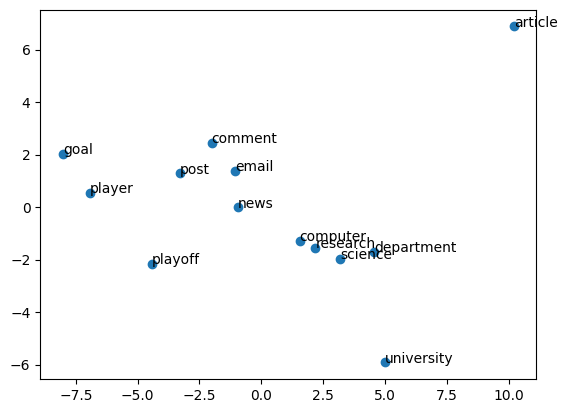

In [59]:
def plot_similar_groups(words: list[str], model: Word2Vec):
    from sklearn.decomposition import PCA
    import matplotlib.pyplot as plt
    result = []
    word_vectors = []
    for word in words:
        word_vector = model.wv[word]
        word_vectors.append(word_vector)
    pca = PCA(n_components=2)
    pca.fit(word_vectors)
    for word in words:
        result.append([word, *pca.transform([model.wv[word]])[0]])

    result = pd.DataFrame(result)
    result.columns = ['word', 'x', 'y']
    result.set_index('word', inplace=True)
    plt.scatter(result['x'].values, result['y'].values)
    for i, txt in enumerate(result.index):
        plt.annotate(txt, (result['x'].values[i], result['y'].values[i]))
    plt.show()
    
    
plot_similar_groups([*hockey_group, *education_research_group, *media_communication_group], model)


## Задание 4

## Задание 7-8

In [10]:
tfidf_matrix = pd.read_csv('../../assets/tf_idf_matrix.csv', usecols=['word', 'mean_tf_idf_score'])

def vectorize_document(doc, model):
    document_vector = np.zeros(VECTOR_SIZE)
    for sentence in doc:
        sentence_vector = vectorize_sentence(sentence, model)
        document_vector += sentence_vector
    document_vector /= len(doc)
    return document_vector

def vectorize_sentence(sentence, model: Word2Vec):
    sentence_vector = np.zeros(VECTOR_SIZE)
    for w in sentence:
        if model.wv.has_index_for(w):
            sentence_vector += model.wv.get_vector(w)
    sentence_vector /= len(sentence)
    return sentence_vector

def get_word_weight(word):
    weight = 1
    try:
        tf_idf = tfidf_matrix[tfidf_matrix['word'] == word]['mean_tf_idf_score'].values
        if len(tf_idf) and tf_idf > 0:
            weight = 1 / tf_idf
    except:
        pass
    if weight > 0:
        return weight
    return 1

def vectorize_sentence_weighted(sentence, model: Word2Vec):
    sentence_vector = np.zeros(VECTOR_SIZE)
    for w in sentence:
        if model.wv.has_index_for(w):
            weighter_word_vector = model.wv.get_vector(w) * get_word_weight(w)
            sentence_vector += weighter_word_vector
    sentence_vector /= len(sentence)
    return sentence_vector

def get_document_annotation(doc_vector):
    return '\t'.join(list(map( str, doc_vector.tolist())))

def save_documents_annotation(path, doc_annotation):
    with open(path, 'w') as f:
        f.writelines(doc_annotation)

def vectorize_documents(filenames, model, annotation_path):
    documents_annotations = ''
    for i, fname in enumerate(filenames):
        _, doc = read_data_with_filter(fname)
        doc_vector = vectorize_document(doc, model)
        documents_annotations += f'{i+1:04}\t'
        documents_annotations += get_document_annotation(doc_vector) + '\n'

    save_documents_annotation(annotation_path, documents_annotations)

In [213]:
import os
data_path = '..\\..\\assets\\annotated-corpus\\hockey_train'
annot_path = '..\\..\\assets\\hockey_annotations_weighted_.txt'

filenames = [os.path.join(data_path, fname) for fname in os.listdir(data_path)]
vectorize_documents(filenames, model, annot_path)

In [14]:
data_path = '..\\..\\assets\\annotated-corpus\\'
annot_path = '..\\..\\assets\\vectorized\\'

model = Word2Vec.load('..\\..\\assets\\big_model')

for topic in topics[1:]:
    cur_data_path = os.path.join(data_path, topic)
    cur_annot_path = os.path.join(annot_path, topic) + '.tsv'
    files = os.listdir(cur_data_path)
    filenames = [os.path.join(cur_data_path, fname) for fname in files]
    print(f'number of files in topic `{topic}`: ', len(filenames))
    vectorize_documents(filenames, model, cur_annot_path)

number of files in topic `electronics`:  393
number of files in topic `hockey`:  399
number of files in topic `med`:  396
number of files in topic `motorcycles`:  398
number of files in topic `space`:  394
